# Section 1
## balancing data with SMOTE
## Create a balanced dataset

In [2]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

df = pd.read_csv("cleaned_dataset.csv")
df = df.dropna(subset=["Expire"]).copy()
df["Expire"] = df["Expire"].astype(int)

X = df.drop(columns=["Expire"])
y = df["Expire"]

print("Before SMOTE:\n", y.value_counts())
print(" UnBalanced shape:", X.shape)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
])

X_encoded = preprocess.fit_transform(X)

smote = SMOTE(random_state=42, k_neighbors=5)
X_bal, y_bal = smote.fit_resample(X_encoded, y)

print("\nAfter SMOTE:\n", pd.Series(y_bal).value_counts())
print("Balanced shape:", X_bal.shape)

Before SMOTE:
 Expire
0    633
1     89
Name: count, dtype: int64
 UnBalanced shape: (722, 154)

After SMOTE:
 Expire
0    633
1    633
Name: count, dtype: int64
Balanced shape: (1266, 340)


# Section 2
## ML pipeline using your balanced dataset (X_bal, y_bal)

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ----------------------------
# X_bal, y_bal MUST already exist from your balancing code
# X_bal: numpy array (1266, 340)
# y_bal: array/Series length 1266
# ----------------------------
print("Balanced X shape:", X_bal.shape)
print("Balanced y counts:\n", pd.Series(y_bal).value_counts())

# ----------------------------
# Models (paper-like list)
# ----------------------------
models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "LinearSVM": SVC(kernel="linear", probability=True),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SGD": SGDClassifier(loss="log_loss", random_state=42),
    "GaussianNB": GaussianNB(),
    "KNN_k3": KNeighborsClassifier(n_neighbors=3),
    "KNN_k4": KNeighborsClassifier(n_neighbors=4),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=600, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=600, random_state=42, n_jobs=-1),
    "GradBoost": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

if HAS_XGB:
    models["XGBoost"] = XGBClassifier(
        n_estimators=1200,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        min_child_weight=1,
        gamma=0,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    )

# ----------------------------
# 10-fold CV + scoring
# ----------------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "acc": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "pr_auc": "average_precision",
    "roc_auc": "roc_auc",
}

# ----------------------------
# Evaluate all models on balanced data
# ----------------------------
rows = []
for name, clf in models.items():
    out = cross_validate(clf, X_bal, y_bal, cv=cv, scoring=scoring, n_jobs=-1)
    rows.append({
        "model": name,
        "PR-AUC": float(np.mean(out["test_pr_auc"])),
        "F1": float(np.mean(out["test_f1"])),
        "Recall": float(np.mean(out["test_recall"])),
        "Precision": float(np.mean(out["test_precision"])),
        "Accuracy": float(np.mean(out["test_acc"])),
        "ROC-AUC": float(np.mean(out["test_roc_auc"])),
    })

res = pd.DataFrame(rows).sort_values(["PR-AUC", "F1"], ascending=False).reset_index(drop=True)
print("\n=== 10-fold CV results on BALANCED dataset ===")
print(res.to_string(index=False))

# ----------------------------
# Voting Top3 / Top4 (like the paper)
# ----------------------------
top3_names = res["model"].iloc[:3].tolist()
top4_names = res["model"].iloc[:4].tolist()

print("\nTop3 by PR-AUC:", top3_names)
print("Top4 by PR-AUC:", top4_names)

def eval_voting(selected_names, label):
    vote = VotingClassifier(
        estimators=[(n, models[n]) for n in selected_names],
        voting="soft"
    )
    out = cross_validate(vote, X_bal, y_bal, cv=cv, scoring=scoring, n_jobs=-1)
    return {
        "model": label + "(" + ",".join(selected_names) + ")",
        "PR-AUC": float(np.mean(out["test_pr_auc"])),
        "F1": float(np.mean(out["test_f1"])),
        "Recall": float(np.mean(out["test_recall"])),
        "Precision": float(np.mean(out["test_precision"])),
        "Accuracy": float(np.mean(out["test_acc"])),
        "ROC-AUC": float(np.mean(out["test_roc_auc"])),
    }

vote_rows = [
    eval_voting(top3_names, "Voting-Top3"),
    eval_voting(top4_names, "Voting-Top4"),
]

print("\n=== Voting results on BALANCED dataset ===")
print(pd.DataFrame(vote_rows).to_string(index=False))


Balanced X shape: (1266, 340)
Balanced y counts:
 Expire
0    633
1    633
Name: count, dtype: int64

=== 10-fold CV results on BALANCED dataset ===
       model   PR-AUC       F1   Recall  Precision  Accuracy  ROC-AUC
RandomForest 0.990525 0.941323 0.938418   0.944566  0.941614 0.989845
     XGBoost 0.990146 0.939759 0.936781   0.943618  0.940014 0.988713
   GradBoost 0.986522 0.933912 0.927331   0.941154  0.934477 0.984804
         MLP 0.986355 0.953492 0.996850   0.914156  0.951081 0.992289
    AdaBoost 0.969241 0.905090 0.925744   0.886771  0.902881 0.968958
      LogReg 0.871406 0.903425 0.965228   0.849613  0.896600 0.926141
         SGD 0.861824 0.877304 0.900422   0.856964  0.874466 0.913696
   LinearSVM 0.852441 0.909696 0.974727   0.853662  0.902906 0.916630
DecisionTree 0.837364 0.881300 0.883036   0.881947  0.881552 0.881523
      KNN_k4 0.834889 0.837888 0.992113   0.725795  0.807293 0.898912
      KNN_k3 0.823564 0.824145 0.998437   0.702244  0.785996 0.891850
  GaussianN

# Section 3
## ✅ Option 1A: RandomForest importance (fast + simple)

Saved: feature_importance_rf_aggregated.csv
 Rank           Feature  Importance  Importance_pct  Cumulative_pct
    1         Condition    0.098590        9.858970        9.858970
    2         Pathology    0.056849        5.684899       15.543869
    3         Diagnosis    0.053361        5.336106       20.879976
    4    Classification    0.052798        5.279847       26.159822
    5       Blood.Group    0.040033        4.003279       30.163102
    6          Etiology    0.031807        3.180655       33.343756
    7     Pathology.new    0.031602        3.160227       36.503983
    8              age1    0.028124        2.812400       39.316383
    9        Center.BMD    0.014438        1.443797       40.760181
   10               Age    0.013283        1.328323       42.088503
   11            Hip.BD    0.013130        1.313012       43.401515
   12       ANDROIDLEAN    0.011641        1.164105       44.565621
   13               PSC    0.011314        1.131421       45.697042
   1

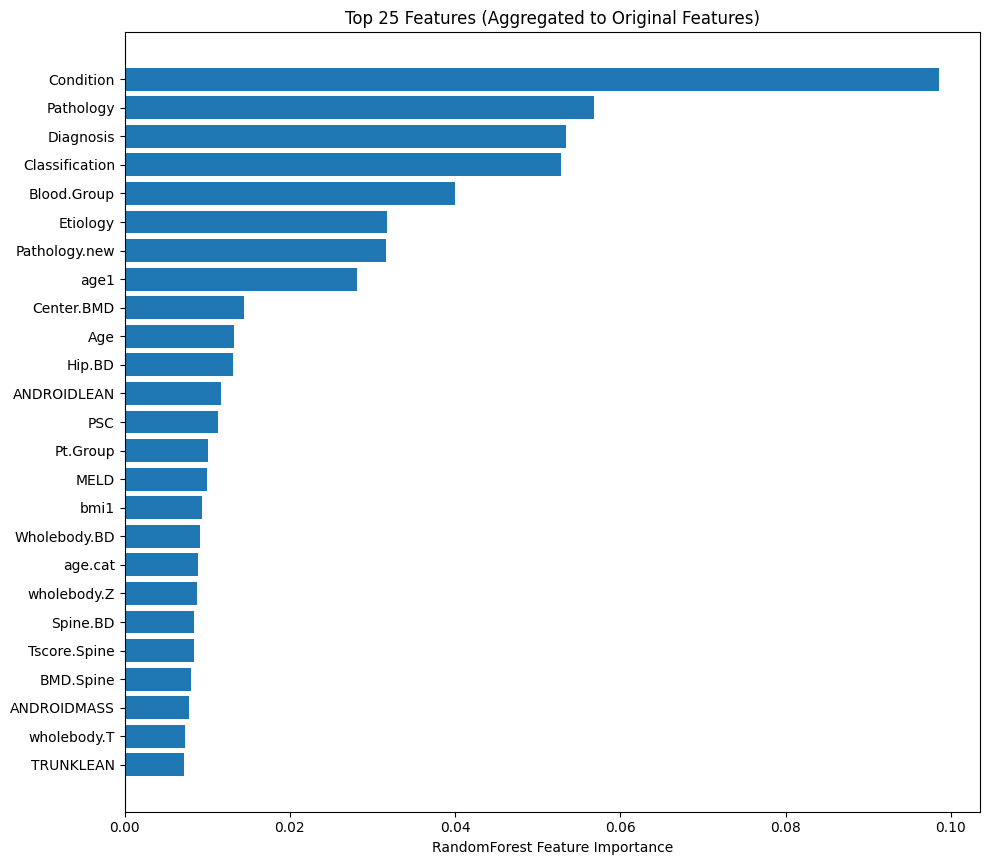

Saved: rf_cumulative_importance_aggregated.png


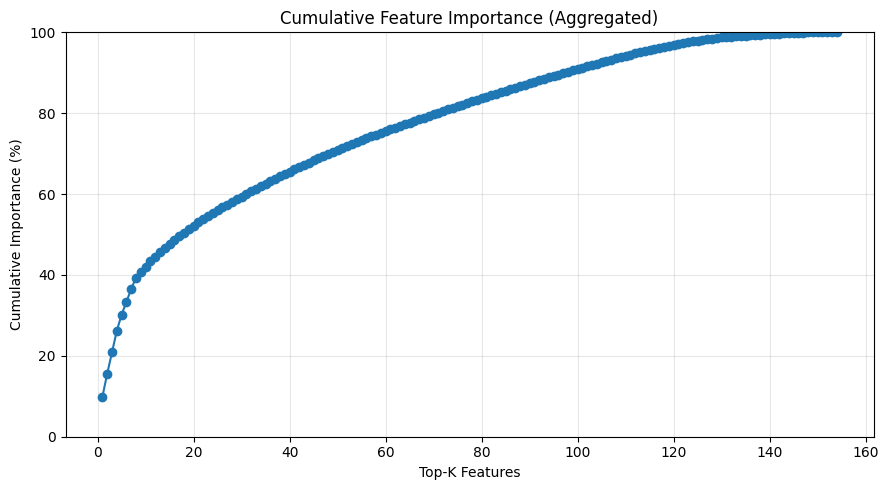

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier

# ---------------------------
# 1) Fit a model on BALANCED data
# ---------------------------
rf = RandomForestClassifier(
    n_estimators=800,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_bal, y_bal)

# ---------------------------
# 2) Get encoded feature names from preprocess
# ---------------------------
encoded_names = preprocess.get_feature_names_out()
encoded_names = list(encoded_names)
assert len(encoded_names) == X_bal.shape[1], "Feature-name count != X_bal columns"

# ---------------------------
# 3) Aggregate encoded -> original feature name
# ---------------------------
def encoded_to_original(name: str) -> str:
    if name.startswith("num__"):
        return name.replace("num__", "")
    if name.startswith("cat__"):
        tmp = name.replace("cat__", "")
        return tmp.split("_", 1)[0]   # keep original feature before first underscore
    return name

imp_encoded = pd.Series(rf.feature_importances_, index=encoded_names)

agg = defaultdict(float)
for enc_name, val in imp_encoded.items():
    agg[encoded_to_original(enc_name)] += float(val)

feat_imp = (
    pd.DataFrame(agg.items(), columns=["Feature", "Importance"])
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)

# Add % and cumulative %
feat_imp["Importance_pct"] = 100 * feat_imp["Importance"] / feat_imp["Importance"].sum()
feat_imp["Cumulative_pct"] = feat_imp["Importance_pct"].cumsum()
feat_imp.insert(0, "Rank", np.arange(1, len(feat_imp) + 1))

# ---------------------------
# 4) Save + show table
# ---------------------------
feat_imp.to_csv("feature_importance_rf_aggregated.csv", index=False)
print("Saved:", "feature_importance_rf_aggregated.csv")
print(feat_imp.head(30).to_string(index=False))
# ---------------------------
# 5) Plot: Top-N bar chart (SAVE high-quality PNG)
# ---------------------------
TOP_N = 25
top = feat_imp.head(TOP_N).iloc[::-1]  # reverse for barh

fig, ax = plt.subplots(figsize=(10, max(6, TOP_N * 0.35)))
ax.barh(top["Feature"], top["Importance"])
ax.set_xlabel("RandomForest Feature Importance")
ax.set_title(f"Top {TOP_N} Features (Aggregated to Original Features)")
fig.tight_layout()

out1 = "rf_top_features_aggregated.png"
fig.savefig(out1, dpi=600, bbox_inches="tight", facecolor="white")
print("Saved:", out1)

plt.show()
plt.close(fig)


# ---------------------------
# 6) Plot: Cumulative importance (SAVE high-quality PNG)
# ---------------------------
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(feat_imp["Rank"], feat_imp["Cumulative_pct"], marker="o")
ax.set_ylim(0, 100)
ax.set_xlabel("Top-K Features")
ax.set_ylabel("Cumulative Importance (%)")
ax.set_title("Cumulative Feature Importance (Aggregated)")
ax.grid(True, alpha=0.3)
fig.tight_layout()

out2 = "rf_cumulative_importance_aggregated.png"
fig.savefig(out2, dpi=600, bbox_inches="tight", facecolor="white")
print("Saved:", out2)

plt.show()
plt.close(fig)

# ✅ Option 1B: XGBoost “gain” importance (often more informative)

Saved: feature_importance_xgb_gain_aggregated.csv
 Rank               Feature       Gain  Gain_pct  Cumulative_pct
    1             Condition 105.264690 22.824180       22.824180
    2              Etiology  26.391329  5.722341       28.546520
    3        Classification  25.432462  5.514433       34.060953
    4         Pathology.new  22.628335  4.906424       38.967377
    5             Pathology  22.108078  4.793618       43.760996
    6              Pt.Group  17.591711  3.814350       47.575346
    7                  age1  13.910091  3.016077       50.591423
    8              Spine.BD  12.533759  2.717652       53.309074
    9            Center.BMD  11.324617  2.455478       55.764552
   10             Diagnosis  10.961141  2.376666       58.141218
   11          Wholebody.BD   8.287575  1.796966       59.938185
   12                Hip.BD   7.174448  1.555611       61.493796
   13           Blood.Group   6.461884  1.401108       62.894904
   14     Menopausal.Female   5.725437  

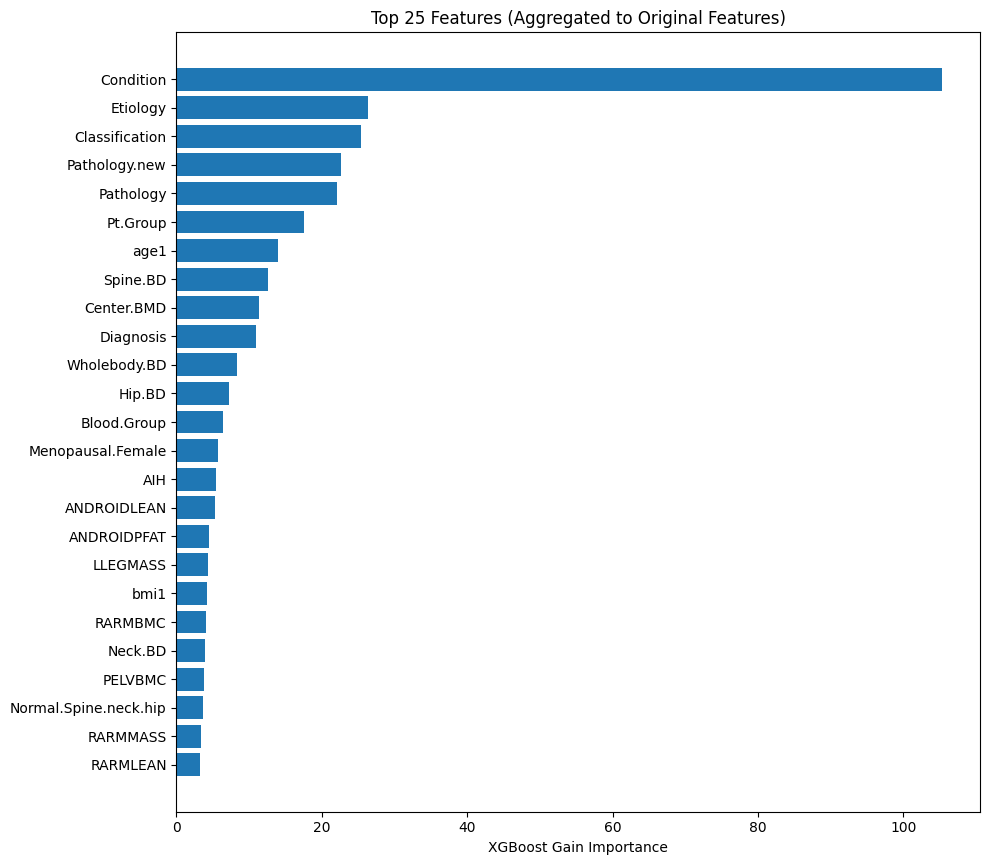

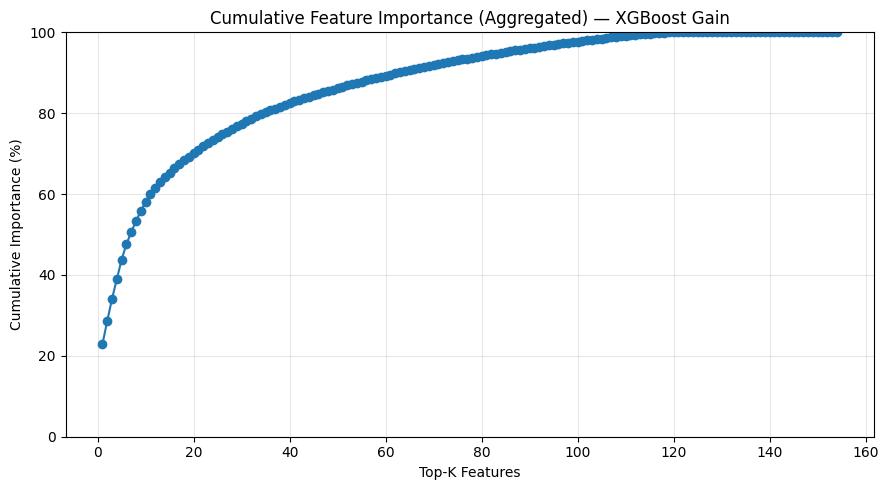

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from xgboost import XGBClassifier

# ---------------------------
# 1) Fit XGBoost on BALANCED data
# ---------------------------
xgb = XGBClassifier(
    n_estimators=1200,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)
xgb.fit(X_bal, y_bal)

# ---------------------------
# 2) Get encoded feature names
# ---------------------------
encoded_names = list(preprocess.get_feature_names_out())
assert len(encoded_names) == X_bal.shape[1], "Feature-name count != X_bal columns"

def encoded_to_original(name: str) -> str:
    if name.startswith("num__"):
        return name.replace("num__", "")
    if name.startswith("cat__"):
        tmp = name.replace("cat__", "")
        return tmp.split("_", 1)[0]
    return name

# ---------------------------
# 3) Pull gain importance and map f0->encoded feature
# ---------------------------
booster = xgb.get_booster()
raw = booster.get_score(importance_type="gain")  # dict: f0,f1,...

imp_encoded = pd.Series(0.0, index=encoded_names)
for k, v in raw.items():
    if k.startswith("f") and k[1:].isdigit():
        idx = int(k[1:])
        if 0 <= idx < len(encoded_names):
            imp_encoded.iloc[idx] = float(v)

# ---------------------------
# 4) Aggregate encoded -> original
# ---------------------------
agg = defaultdict(float)
for enc_name, val in imp_encoded.items():
    agg[encoded_to_original(enc_name)] += float(val)

feat_imp = (
    pd.DataFrame(agg.items(), columns=["Feature", "Gain"])
    .sort_values("Gain", ascending=False)
    .reset_index(drop=True)
)

total = feat_imp["Gain"].sum()
feat_imp["Gain_pct"] = 100 * feat_imp["Gain"] / (total if total != 0 else 1)
feat_imp["Cumulative_pct"] = feat_imp["Gain_pct"].cumsum()
feat_imp.insert(0, "Rank", np.arange(1, len(feat_imp) + 1))

feat_imp.to_csv("feature_importance_xgb_gain_aggregated.csv", index=False)
print("Saved:", "feature_importance_xgb_gain_aggregated.csv")
print(feat_imp.head(30).to_string(index=False))

# Plot Top-N
TOP_N = 25
top = feat_imp.head(TOP_N).iloc[::-1]

plt.figure(figsize=(10, max(6, TOP_N * 0.35)))
plt.barh(top["Feature"], top["Gain"])
plt.xlabel("XGBoost Gain Importance")
plt.title(f"Top {TOP_N} Features (Aggregated to Original Features)")
plt.tight_layout()
plt.show()

# Cumulative curve
plt.figure(figsize=(9, 5))
plt.plot(feat_imp["Rank"], feat_imp["Cumulative_pct"], marker="o")
plt.ylim(0, 100)
plt.xlabel("Top-K Features")
plt.ylabel("Cumulative Importance (%)")
plt.title("Cumulative Feature Importance (Aggregated) — XGBoost Gain")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Code: check that these “Top 30” features truly exist in your original dataframe

In [11]:
import pandas as pd
from difflib import get_close_matches

# Your Top 30 feature names (exactly as printed)
top_features = [
    "Condition","Etiology","Classification","Pathology.new","Pathology",
    "Pt.Group","age1","Spine.BD","Center.BMD","Diagnosis",
    "Wholebody.BD","Hip.BD","Blood.Group","Menopausal.Female","AIH",
    "ANDROIDLEAN","ANDROIDPFAT","LLEGMASS","bmi1","RARMBMC",
    "Neck.BD","PELVBMC","Normal.Spine.neck.hip","RARMMASS","RARMLEAN",
    "HBV","WEIGHTT","TRUNKLEAN","cryptogenic","TRUNKFAT"
]

df_cols = list(df.columns)

# Found / missing
found = [f for f in top_features if f in df_cols]
missing = [f for f in top_features if f not in df_cols]

print("✅ Found in df:", len(found))
print(found)

print("\n❌ Missing from df:", len(missing))
print(missing)

# Suggest close matches for missing ones
if missing:
    print("\n--- Closest matches suggestions ---")
    for m in missing:
        matches = get_close_matches(m, df_cols, n=5, cutoff=0.6)
        print(f"{m} -> {matches}")


✅ Found in df: 30
['Condition', 'Etiology', 'Classification', 'Pathology.new', 'Pathology', 'Pt.Group', 'age1', 'Spine.BD', 'Center.BMD', 'Diagnosis', 'Wholebody.BD', 'Hip.BD', 'Blood.Group', 'Menopausal.Female', 'AIH', 'ANDROIDLEAN', 'ANDROIDPFAT', 'LLEGMASS', 'bmi1', 'RARMBMC', 'Neck.BD', 'PELVBMC', 'Normal.Spine.neck.hip', 'RARMMASS', 'RARMLEAN', 'HBV', 'WEIGHTT', 'TRUNKLEAN', 'cryptogenic', 'TRUNKFAT']

❌ Missing from df: 0
[]


# 2) Correlation matrix (numeric features) + top correlated pairs

This will:

## compute correlation on original numeric columns in df (before OneHot)

## plot a heatmap using matplotlib

## print top correlated pairs (absolute correlation) so you can discuss multicollinearity

Correlation matrix shape: (136, 136)


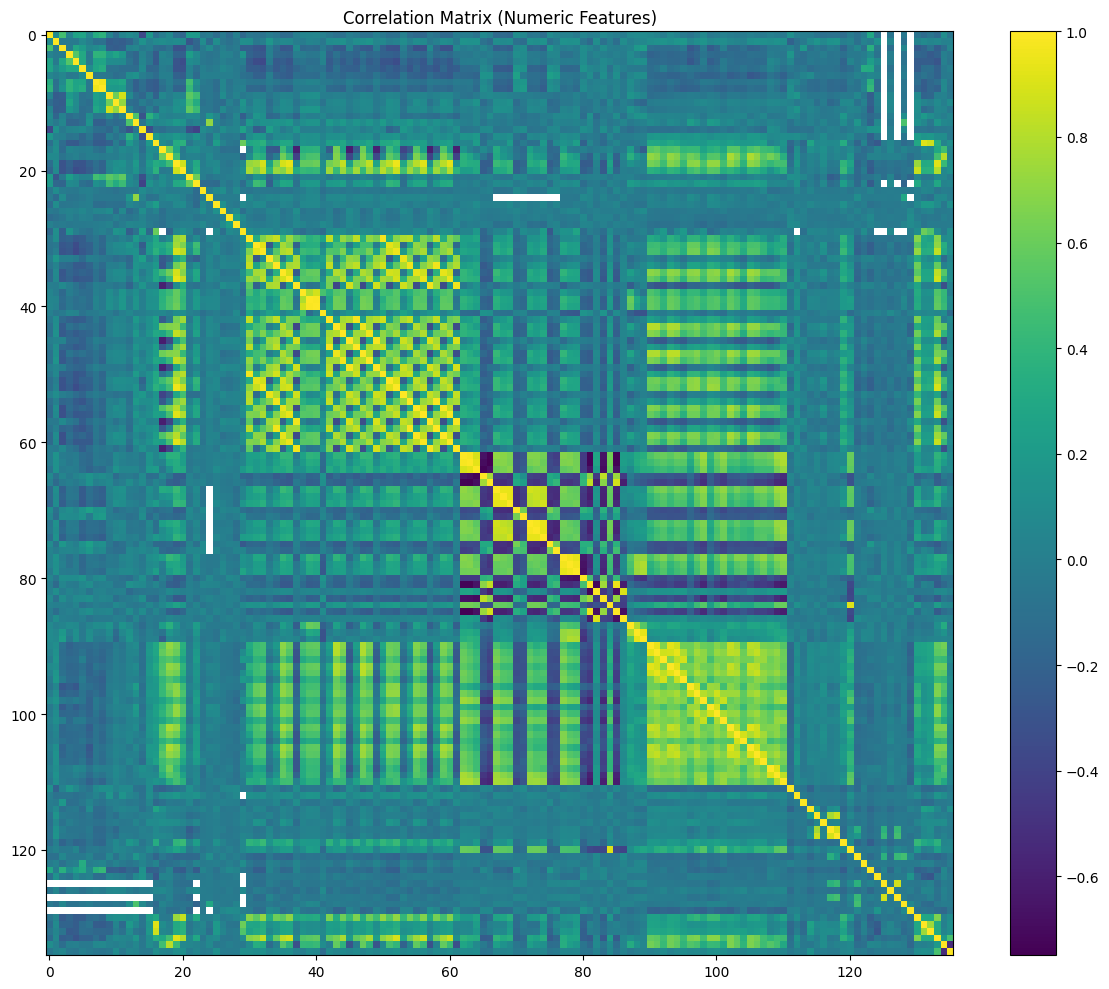


Top 30 correlated pairs (absolute correlation):
         Feature_1                   Feature_2  AbsCorr
           LLEGFAT                     RLEGFAT 0.989588
          HEADLEAN                    HEADMASS 0.987657
          LLEGMASS                    RLEGMASS 0.985916
          LLEGPFAT                    RLEGPFAT 0.984708
         BMD.Spine                Tscore.Spine 0.982432
          LLEGLEAN                    RLEGLEAN 0.979523
           LARMFAT                     RARMFAT 0.975961
          LARMPFAT                    RARMPFAT 0.974362
    BMD.Neck.Femur           Tscore.Neck.Femur 0.973933
    BMD.Total.Body                 wholebody.T 0.969384
       wholebody.T                 wholebody.Z 0.966773
        ANDROIDFAT                    TRUNKFAT 0.966231
        GYNOIDPFAT                    LLEGPFAT 0.965628
        GYNOIDPFAT                    RLEGPFAT 0.964726
         GYNOIDFAT                     LLEGFAT 0.964245
         GYNOIDFAT                     RLEGFAT 0.963408

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use your original dataframe df (unencoded)
# df = pd.read_csv("cleaned_dataset.csv")  # if needed

num_df = df.select_dtypes(include=[np.number]).copy()

# Optional: drop target if it is numeric and you don't want it in the matrix
if "Expire" in num_df.columns:
    num_df = num_df.drop(columns=["Expire"])

# Compute correlation
corr = num_df.corr(method="pearson")

print("Correlation matrix shape:", corr.shape)

# -------- Heatmap (matplotlib) --------
plt.figure(figsize=(12, 10))
im = plt.imshow(corr.values, aspect="auto")
plt.colorbar(im)
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()

# -------- Top correlated pairs --------
# Convert matrix to pairs (upper triangle only)
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

pairs = (
    upper.stack()
    .sort_values(ascending=False)
    .reset_index()
)
pairs.columns = ["Feature_1", "Feature_2", "AbsCorr"]

print("\nTop 30 correlated pairs (absolute correlation):")
print(pairs.head(30).to_string(index=False))


# 1) Top 30 NUMERIC correlation heatmap

Top30 numeric features: ['Weight', 'RLEGBMC', 'RARMBMC', 'LRIBBMC', 'RRIBBMC', 'GYNOIDMASS', 'TRUNKMASS', 'LARMBMC', 'RARMAREA', 'GYNOIDLEAN', 'LLEGAREA', 'WEIGHTT', 'RLEGMASS', 'LLEGMASS', 'LLEGBMC', 'RLEGAREA', 'RARMMASS', 'LARMMASS', 'LARMAREA', 'LRIBBMD', 'TRUNKLEAN', 'PELVBMC', 'RLEGLEAN', 'LLEGLEAN', 'PELVBMD', 'RARMLEAN', 'RLEGBMD', 'LARMBMD', 'RRIBBMD', 'LARMLEAN']


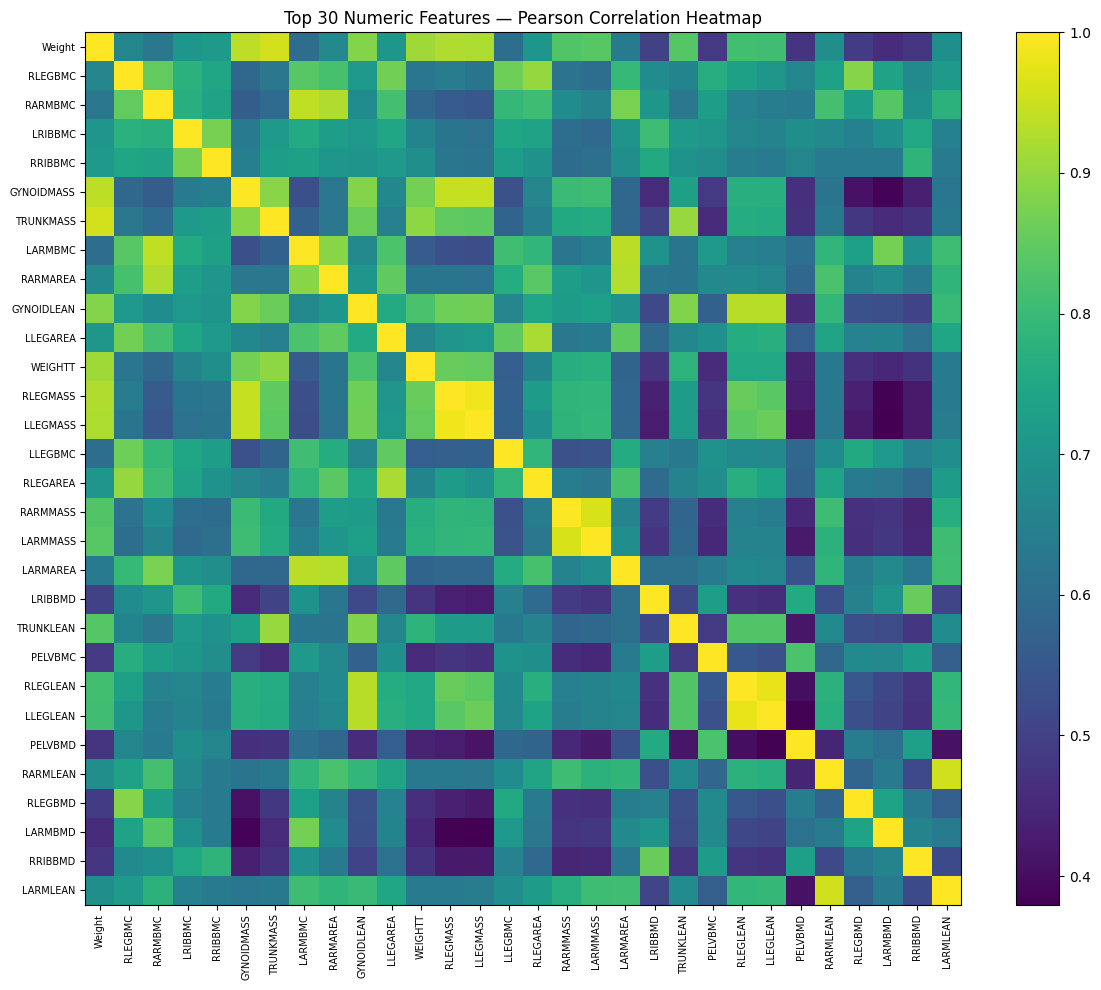

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- numeric dataframe ---
num_df = df.select_dtypes(include=[np.number]).copy()
if "Expire" in num_df.columns:
    num_df = num_df.drop(columns=["Expire"])

corr = num_df.corr(method="pearson")

# pick top 30 numeric columns by highest mean absolute correlation
mean_abs = corr.abs().mean().sort_values(ascending=False)
top30_num = mean_abs.head(30).index.tolist()

corr30 = corr.loc[top30_num, top30_num]

print("Top30 numeric features:", top30_num)

# --- heatmap ---
plt.figure(figsize=(12, 10))
im = plt.imshow(corr30.values, aspect="auto")
plt.colorbar(im)
plt.title("Top 30 Numeric Features — Pearson Correlation Heatmap")

plt.xticks(range(len(top30_num)), top30_num, rotation=90, fontsize=7)
plt.yticks(range(len(top30_num)), top30_num, fontsize=7)

plt.tight_layout()
plt.show()


# Here’s a simple, reliable way to check whether those Top30 numeric features exist in your original df columns, and also show missing ones + close matches (helpful if there are tiny name differences like spaces/dots).

In [12]:
from difflib import get_close_matches

top30_num = ['Weight', 'RLEGBMC', 'RARMBMC', 'LRIBBMC', 'RRIBBMC', 'GYNOIDMASS',
             'TRUNKMASS', 'LARMBMC', 'RARMAREA', 'GYNOIDLEAN', 'LLEGAREA', 'WEIGHTT',
             'RLEGMASS', 'LLEGMASS', 'LLEGBMC', 'RLEGAREA', 'RARMMASS', 'LARMMASS',
             'LARMAREA', 'LRIBBMD', 'TRUNKLEAN', 'PELVBMC', 'RLEGLEAN', 'LLEGLEAN',
             'PELVBMD', 'RARMLEAN', 'RLEGBMD', 'LARMBMD', 'RRIBBMD', 'LARMLEAN']

df_cols = set(df.columns)

found = [f for f in top30_num if f in df_cols]
missing = [f for f in top30_num if f not in df_cols]

print("✅ Found:", len(found))
print(found)

print("\n❌ Missing:", len(missing))
print(missing)

# Show close matches for missing (to catch typos / naming differences)
if missing:
    print("\n--- Closest matches in df.columns ---")
    all_cols = list(df.columns)
    for m in missing:
        print(f"{m} -> {get_close_matches(m, all_cols, n=5, cutoff=0.6)}")


✅ Found: 30
['Weight', 'RLEGBMC', 'RARMBMC', 'LRIBBMC', 'RRIBBMC', 'GYNOIDMASS', 'TRUNKMASS', 'LARMBMC', 'RARMAREA', 'GYNOIDLEAN', 'LLEGAREA', 'WEIGHTT', 'RLEGMASS', 'LLEGMASS', 'LLEGBMC', 'RLEGAREA', 'RARMMASS', 'LARMMASS', 'LARMAREA', 'LRIBBMD', 'TRUNKLEAN', 'PELVBMC', 'RLEGLEAN', 'LLEGLEAN', 'PELVBMD', 'RARMLEAN', 'RLEGBMD', 'LARMBMD', 'RRIBBMD', 'LARMLEAN']

❌ Missing: 0
[]


# 2) Top 30 CATEGORICAL “correlation” heatmap (Cramér’s V)

Top categorical features: ['Pathology', 'Diagnosis', 'Pathology.new', 'Classification', 'Etiology', 'Osteoporosis', 'Spine.BD', 'Bone.Disease', 'Wholebody.BD', 'Hip.BD', 'Agecat', 'Neck.BD', 'Menopausal.Female', 'Pt.Group', 'CHILD.Class', 'Condition', 'Blood.Group', 'Center.BMD']


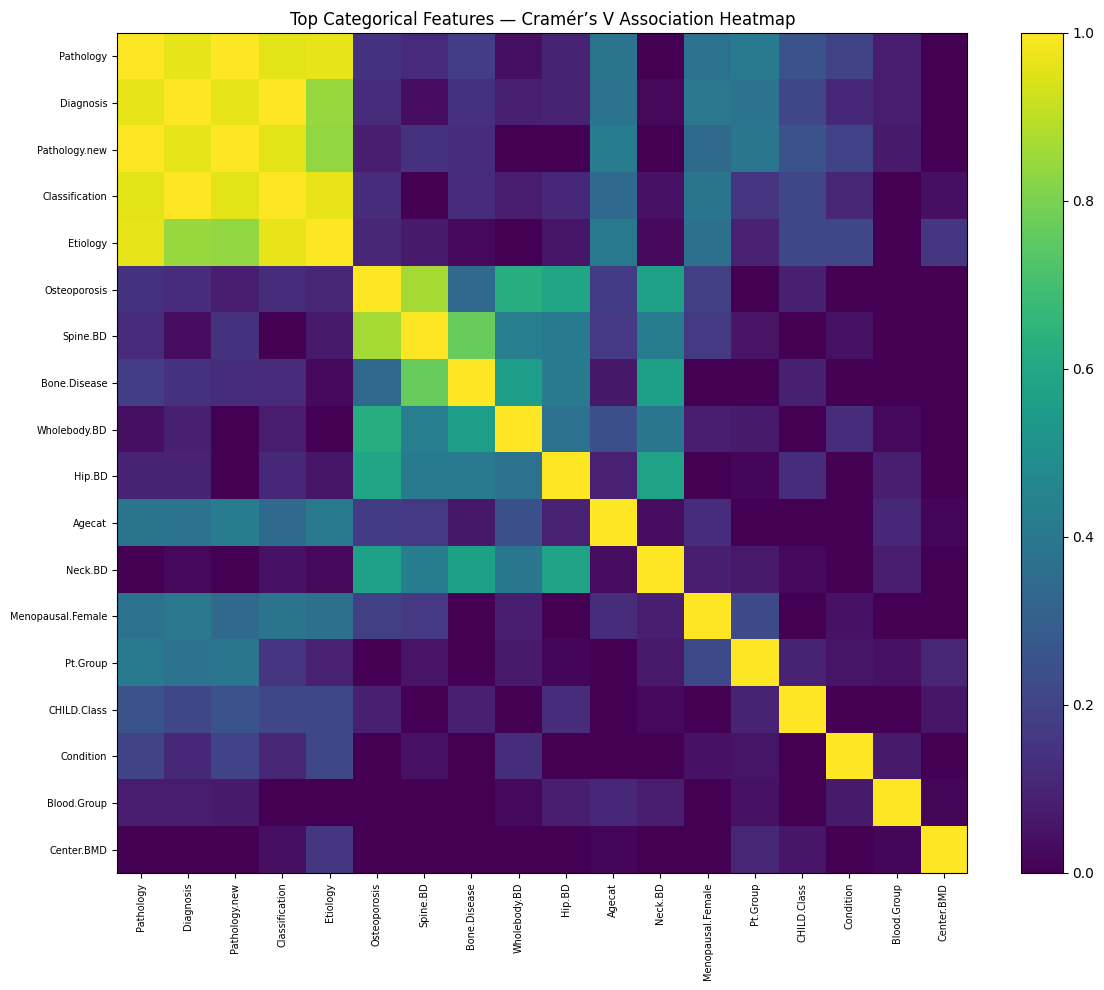

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def cramers_v(x, y) -> float:
    """
    Cramér's V for categorical-categorical association (0..1).
    Uses bias correction (recommended).
    """
    confusion = pd.crosstab(x, y)
    n = confusion.values.sum()
    if n == 0:
        return np.nan

    # Chi-square
    obs = confusion.values
    row_sum = obs.sum(axis=1, keepdims=True)
    col_sum = obs.sum(axis=0, keepdims=True)
    expected = row_sum @ col_sum / n

    # avoid division by zero
    with np.errstate(divide="ignore", invalid="ignore"):
        chi2 = np.nansum((obs - expected) ** 2 / expected)

    r, k = confusion.shape
    if r <= 1 or k <= 1:
        return 0.0

    phi2 = chi2 / n

    # Bias correction (Bergsma & Wicher)
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)

    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return 0.0
    return np.sqrt(phi2corr / denom)

# --- categorical dataframe ---
cat_df = df.select_dtypes(exclude=[np.number]).copy()

# If Expire is categorical and you want to exclude it:
if "Expire" in cat_df.columns:
    cat_df = cat_df.drop(columns=["Expire"])

# If you have fewer than 2 categorical columns, stop
if cat_df.shape[1] < 2:
    print("Not enough categorical columns to build a categorical association heatmap.")
else:
    cat_cols = cat_df.columns.tolist()

    # Compute full Cramér's V matrix
    m = len(cat_cols)
    V = np.zeros((m, m), dtype=float)

    for i in range(m):
        V[i, i] = 1.0
        for j in range(i + 1, m):
            v = cramers_v(cat_df.iloc[:, i].astype("category"),
                          cat_df.iloc[:, j].astype("category"))
            V[i, j] = v
            V[j, i] = v

    V_df = pd.DataFrame(V, index=cat_cols, columns=cat_cols)

    # Choose top 30 categorical features by highest mean association with others
    mean_assoc = V_df.replace([np.inf, -np.inf], np.nan).fillna(0).mean().sort_values(ascending=False)
    top30_cat = mean_assoc.head(min(30, len(mean_assoc))).index.tolist()

    V30 = V_df.loc[top30_cat, top30_cat]

    print("Top categorical features:", top30_cat)

    # --- heatmap ---
    plt.figure(figsize=(12, 10))
    im = plt.imshow(V30.values, aspect="auto", vmin=0, vmax=1)
    plt.colorbar(im)
    plt.title("Top Categorical Features — Cramér’s V Association Heatmap")

    plt.xticks(range(len(top30_cat)), top30_cat, rotation=90, fontsize=7)
    plt.yticks(range(len(top30_cat)), top30_cat, fontsize=7)

    plt.tight_layout()
    plt.show()


# Here’s the code to check whether those top categorical features exist in your original df, and to show missing ones + close matches (useful if names differ slightly).

In [13]:
from difflib import get_close_matches

top30_cat = ['Pathology', 'Diagnosis', 'Pathology.new', 'Classification', 'Etiology',
             'Osteoporosis', 'Spine.BD', 'Bone.Disease', 'Wholebody.BD', 'Hip.BD',
             'Agecat', 'Neck.BD', 'Menopausal.Female', 'Pt.Group', 'CHILD.Class',
             'Condition', 'Blood.Group', 'Center.BMD']

df_cols = set(df.columns)

found = [f for f in top30_cat if f in df_cols]
missing = [f for f in top30_cat if f not in df_cols]

print("✅ Found:", len(found))
print(found)

print("\n❌ Missing:", len(missing))
print(missing)

# Suggest close matches for missing ones (to catch typos / dots / underscores)
if missing:
    print("\n--- Closest matches in df.columns ---")
    all_cols = list(df.columns)
    for m in missing:
        print(f"{m} -> {get_close_matches(m, all_cols, n=5, cutoff=0.6)}")


✅ Found: 18
['Pathology', 'Diagnosis', 'Pathology.new', 'Classification', 'Etiology', 'Osteoporosis', 'Spine.BD', 'Bone.Disease', 'Wholebody.BD', 'Hip.BD', 'Agecat', 'Neck.BD', 'Menopausal.Female', 'Pt.Group', 'CHILD.Class', 'Condition', 'Blood.Group', 'Center.BMD']

❌ Missing: 0
[]





# 1) Correlation matrix for Top 30 NUMERIC features (Pearson)



Numeric found: 30 missing: []
Numeric corr matrix shape: (30, 30)


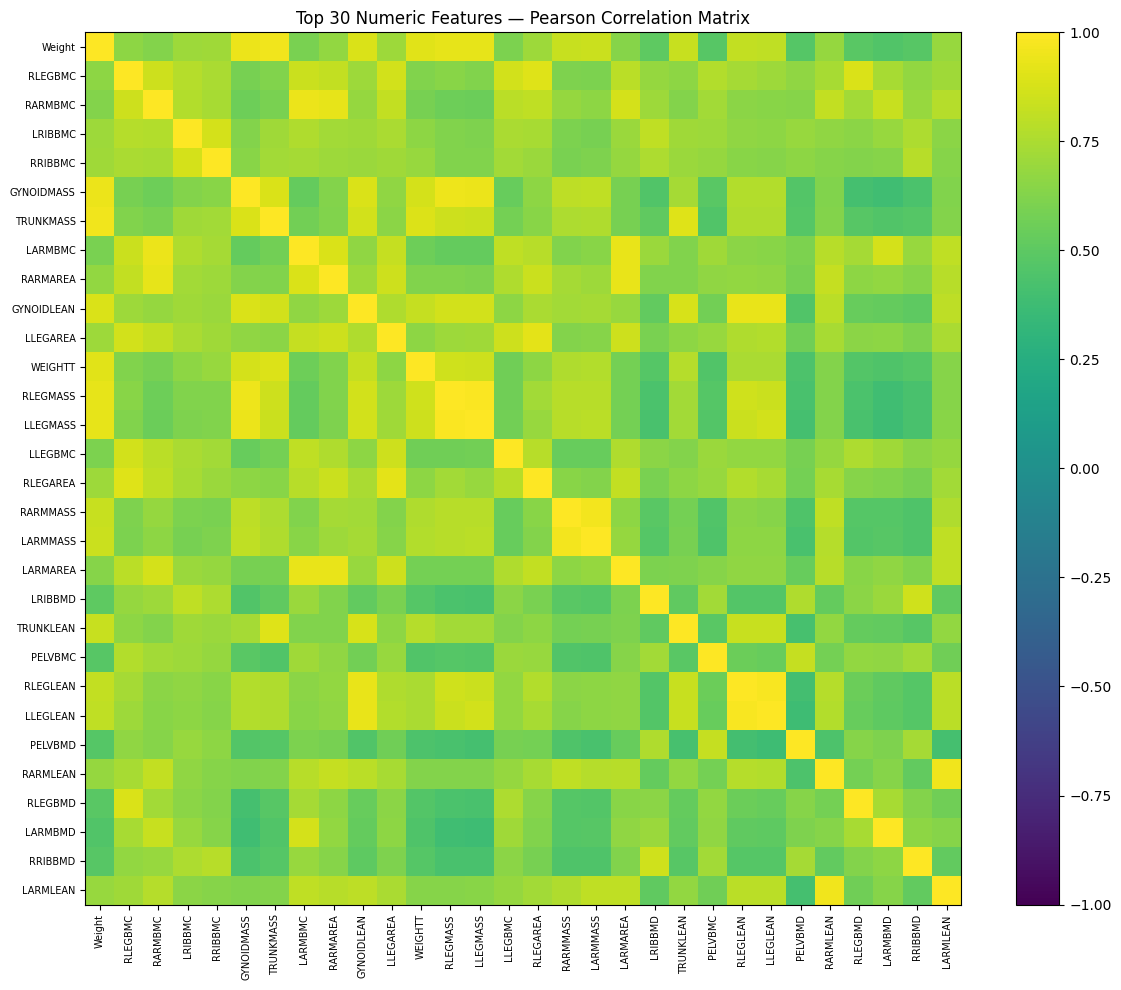

,Weight,RLEGBMC,RARMBMC,LRIBBMC,RRIBBMC,GYNOIDMASS,TRUNKMASS,LARMBMC,RARMAREA,GYNOIDLEAN,...,TRUNKLEAN,PELVBMC,RLEGLEAN,LLEGLEAN,PELVBMD,RARMLEAN,RLEGBMD,LARMBMD,RRIBBMD,LARMLEAN
Weight,1.000000,0.662771,0.625063,0.705216,0.713565,0.938352,0.957409,0.601086,0.672611,0.885397,...,0.835473,0.482587,0.813307,0.811005,0.473282,0.686283,0.490017,0.459357,0.477571,0.689634
RLEGBMC,0.662771,1.000000,0.850711,0.775097,0.745692,0.589274,0.624654,0.839966,0.819681,0.709291,...,0.659645,0.767296,0.732980,0.707443,0.664262,0.735368,0.887060,0.735982,0.674690,0.715259
RARMBMC,0.625063,0.850711,1.000000,0.769793,0.736800,0.562068,0.596189,0.939906,0.927150,0.682489,...,0.626131,0.726038,0.653890,0.640693,0.636710,0.816336,0.726480,0.835708,0.690782,0.778996
LRIBBMC,0.705216,0.775097,0.769793,1.000000,0.871989,0.631880,0.715101,0.758996,0.726167,0.711081,...,0.714252,0.708961,0.664506,0.657656,0.687915,0.671589,0.653108,0.690384,0.751844,0.651627
RRIBBMC,0.713565,0.745692,0.736800,0.871989,1.000000,0.646467,0.725320,0.732142,0.706291,0.700739,...,0.698688,0.686262,0.641363,0.636201,0.662337,0.635239,0.632076,0.636962,0.782346,0.637817
GYNOIDMASS,0.938352,0.589274,0.562068,0.631880,0.646467,1.000000,0.889470,0.530672,0.625242,0.883863,...,0.732821,0.485889,0.768348,0.768101,0.465884,0.618794,0.409773,0.385812,0.434630,0.623177
TRUNKMASS,0.957409,0.624654,0.596189,0.715101,0.725320,0.889470,1.000000,0.571990,0.624509,0.860603,...,0.905449,0.456506,0.763197,0.761463,0.469628,0.629458,0.481311,0.456134,0.471242,0.630115
LARMBMC,0.601086,0.839966,0.939906,0.758996,0.732142,0.530672,0.571990,1.000000,0.889316,0.670507,...,0.621025,0.713636,0.650602,0.645990,0.606329,0.788154,0.730708,0.870434,0.693802,0.806809
RARMAREA,0.672611,0.819681,0.927150,0.726167,0.706291,0.625242,0.624509,0.889316,1.000000,0.704412,...,0.618621,0.670645,0.673757,0.664751,0.589144,0.821373,0.656401,0.678595,0.633648,0.786293
GYNOIDLEAN,0.885397,0.709291,0.682489,0.711081,0.700739,0.883863,0.860603,0.670507,0.704412,1.000000,...,0.882702,0.573530,0.932647,0.932383,0.458576,0.791065,0.536441,0.531151,0.504314,0.799353


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

top30_num = ['Weight', 'RLEGBMC', 'RARMBMC', 'LRIBBMC', 'RRIBBMC', 'GYNOIDMASS',
             'TRUNKMASS', 'LARMBMC', 'RARMAREA', 'GYNOIDLEAN', 'LLEGAREA', 'WEIGHTT',
             'RLEGMASS', 'LLEGMASS', 'LLEGBMC', 'RLEGAREA', 'RARMMASS', 'LARMMASS',
             'LARMAREA', 'LRIBBMD', 'TRUNKLEAN', 'PELVBMC', 'RLEGLEAN', 'LLEGLEAN',
             'PELVBMD', 'RARMLEAN', 'RLEGBMD', 'LARMBMD', 'RRIBBMD', 'LARMLEAN']

# Keep only columns that exist
top30_num_exist = [c for c in top30_num if c in df.columns]
missing_num = [c for c in top30_num if c not in df.columns]
print("Numeric found:", len(top30_num_exist), "missing:", missing_num)

num30_df = df[top30_num_exist].select_dtypes(include=[np.number]).copy()

corr30_num = num30_df.corr(method="pearson")
print("Numeric corr matrix shape:", corr30_num.shape)

# Heatmap
plt.figure(figsize=(12, 10))
im = plt.imshow(corr30_num.values, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(im)
plt.title("Top 30 Numeric Features — Pearson Correlation Matrix")

plt.xticks(range(len(corr30_num.columns)), corr30_num.columns, rotation=90, fontsize=7)
plt.yticks(range(len(corr30_num.index)), corr30_num.index, fontsize=7)

plt.tight_layout()
plt.show()

# If you want the matrix as a dataframe:
corr30_num


# 2) Association matrix for Top 30 CATEGORICAL features (Cramér’s V)

Categorical found: 18 missing: []
Categorical association matrix shape: (18, 18)


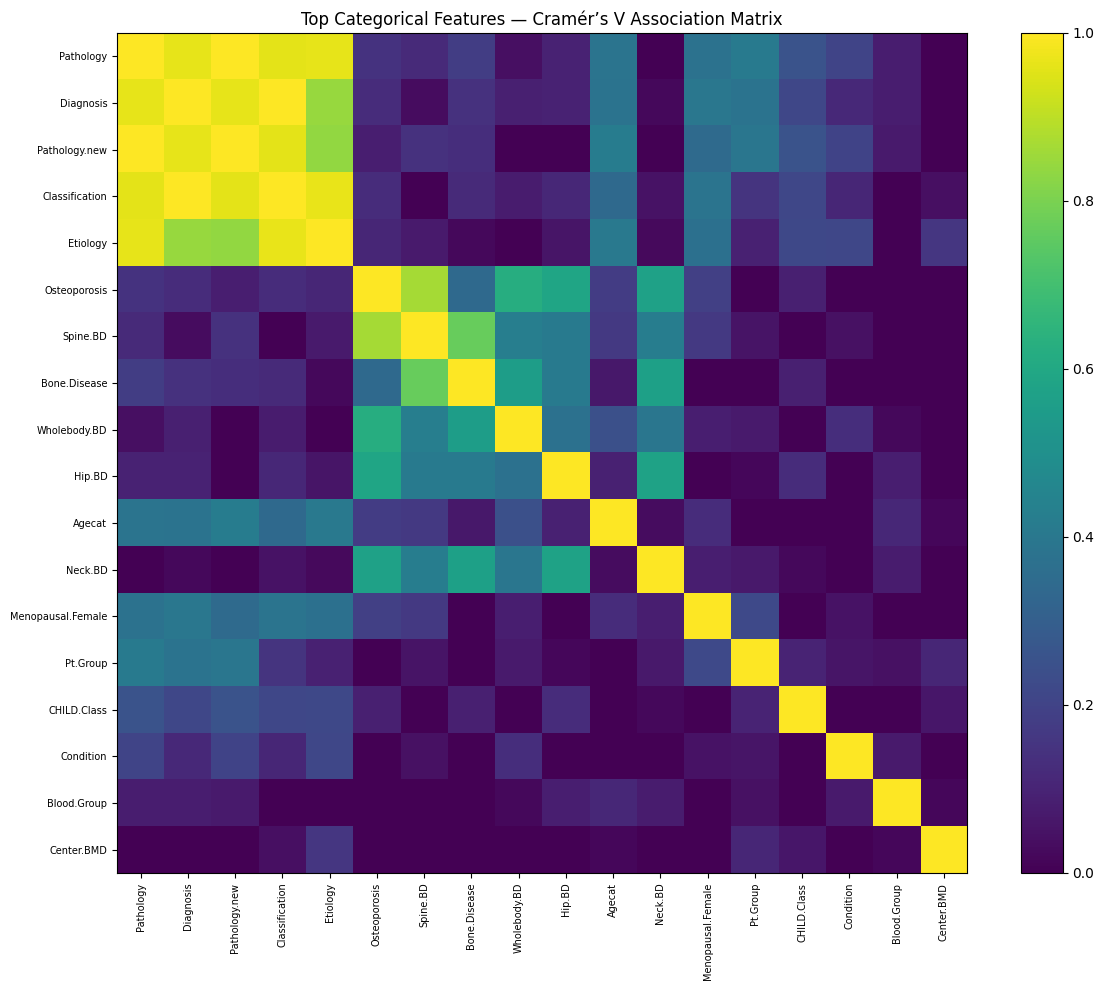

,Pathology,Diagnosis,Pathology.new,Classification,Etiology,Osteoporosis,Spine.BD,Bone.Disease,Wholebody.BD,Hip.BD,Agecat,Neck.BD,Menopausal.Female,Pt.Group,CHILD.Class,Condition,Blood.Group,Center.BMD
Pathology,1.000000,0.962432,1.000000,0.959715,0.962432,0.145770,0.118706,0.183531,0.041824,0.095692,0.384944,0.000000,0.376624,0.411359,0.255653,0.205818,0.080600,0.000000
Diagnosis,0.962432,1.000000,0.961524,0.997182,0.845365,0.126962,0.033569,0.144148,0.089218,0.097619,0.379577,0.020459,0.396223,0.379042,0.214841,0.115050,0.079815,0.000000
Pathology.new,1.000000,0.961524,1.000000,0.958814,0.837735,0.084581,0.141439,0.130318,0.000000,0.000000,0.419431,0.000000,0.346910,0.391689,0.255653,0.199619,0.070763,0.000000
Classification,0.959715,0.997182,0.958814,1.000000,0.964947,0.126657,0.000000,0.120223,0.077262,0.110796,0.343708,0.050764,0.384098,0.148763,0.214841,0.107252,0.000000,0.040930
Etiology,0.962432,0.845365,0.837735,0.964947,1.000000,0.108812,0.073053,0.020774,0.000000,0.057036,0.405669,0.024528,0.367463,0.089923,0.216952,0.213143,0.000000,0.159502
Osteoporosis,0.145770,0.126962,0.084581,0.126657,0.108812,1.000000,0.864354,0.342577,0.621792,0.588128,0.179180,0.573969,0.189453,0.000000,0.088892,0.000000,0.000000,0.000000
Spine.BD,0.118706,0.033569,0.141439,0.000000,0.073053,0.864354,1.000000,0.769523,0.427122,0.411392,0.167388,0.425461,0.165723,0.054210,0.000000,0.046545,0.000000,0.000000
Bone.Disease,0.183531,0.144148,0.130318,0.120223,0.020774,0.342577,0.769523,1.000000,0.555995,0.406729,0.065125,0.566947,0.000000,0.000000,0.089257,0.000000,0.000000,0.000000
Wholebody.BD,0.041824,0.089218,0.000000,0.077262,0.000000,0.621792,0.427122,0.555995,1.000000,0.372327,0.243114,0.391133,0.085286,0.072947,0.000000,0.130049,0.020103,0.000000
Hip.BD,0.095692,0.097619,0.000000,0.110796,0.057036,0.588128,0.411392,0.406729,0.372327,1.000000,0.092927,0.577690,0.000000,0.018049,0.125205,0.000000,0.082254,0.000000


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def cramers_v(x, y) -> float:
    confusion = pd.crosstab(x, y)
    n = confusion.values.sum()
    if n == 0:
        return np.nan

    obs = confusion.values
    row_sum = obs.sum(axis=1, keepdims=True)
    col_sum = obs.sum(axis=0, keepdims=True)
    expected = row_sum @ col_sum / n

    with np.errstate(divide="ignore", invalid="ignore"):
        chi2 = np.nansum((obs - expected) ** 2 / expected)

    r, k = confusion.shape
    if r <= 1 or k <= 1:
        return 0.0

    phi2 = chi2 / n

    # Bias correction
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

top30_cat = ['Pathology', 'Diagnosis', 'Pathology.new', 'Classification', 'Etiology',
             'Osteoporosis', 'Spine.BD', 'Bone.Disease', 'Wholebody.BD', 'Hip.BD',
             'Agecat', 'Neck.BD', 'Menopausal.Female', 'Pt.Group', 'CHILD.Class',
             'Condition', 'Blood.Group', 'Center.BMD']

# Keep only columns that exist
top30_cat_exist = [c for c in top30_cat if c in df.columns]
missing_cat = [c for c in top30_cat if c not in df.columns]
print("Categorical found:", len(top30_cat_exist), "missing:", missing_cat)

cat30_df = df[top30_cat_exist].copy()

# Ensure categorical dtype (safe)
for c in cat30_df.columns:
    cat30_df[c] = cat30_df[c].astype("category")

m = len(cat30_df.columns)
V = np.zeros((m, m), dtype=float)

cols = cat30_df.columns.tolist()
for i in range(m):
    V[i, i] = 1.0
    for j in range(i + 1, m):
        v = cramers_v(cat30_df.iloc[:, i], cat30_df.iloc[:, j])
        V[i, j] = v
        V[j, i] = v

V30 = pd.DataFrame(V, index=cols, columns=cols)
print("Categorical association matrix shape:", V30.shape)

# Heatmap
plt.figure(figsize=(12, 10))
im = plt.imshow(V30.values, aspect="auto", vmin=0, vmax=1)
plt.colorbar(im)
plt.title("Top Categorical Features — Cramér’s V Association Matrix")

plt.xticks(range(len(cols)), cols, rotation=90, fontsize=7)
plt.yticks(range(len(cols)), cols, fontsize=7)

plt.tight_layout()
plt.show()

# If you want the matrix as a dataframe:
V30




# 0) Helper: annotated heatmap function (matplotlib)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_annotated_heatmap(mat, labels, title, vmin, vmax, cmap="Greens",
                           fmt="{:.2f}", fontsize=7, fig_size=(12, 10)):
    """
    mat: 2D numpy array
    labels: list of feature names (same order for rows/cols)
    """
    mat = np.asarray(mat)
    n = mat.shape[0]

    plt.figure(figsize=fig_size)
    im = plt.imshow(mat, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.title(title)

    plt.xticks(range(n), labels, rotation=90, fontsize=fontsize)
    plt.yticks(range(n), labels, fontsize=fontsize)

    # Write values inside each cell
    for i in range(n):
        for j in range(n):
            val = mat[i, j]
            if np.isnan(val):
                txt = "NA"
            else:
                txt = fmt.format(val)
            plt.text(j, i, txt, ha="center", va="center", fontsize=fontsize-1, color="black")

    plt.tight_layout()
    plt.show()


# section 4
## 1) Top 30 NUMERIC correlation matrix (annotated like your image)

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_annotated_heatmap(
    mat, labels, title="Heatmap",
    vmin=None, vmax=None, cmap="Greens",
    fmt="{:.2f}", fontsize=7,
    fig_size=(12, 10)
):
    fig, ax = plt.subplots(figsize=fig_size)

    im = ax.imshow(mat, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Pearson r")

    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize)
    ax.set_yticklabels(labels, fontsize=fontsize)

    # annotate cells
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, fmt.format(mat[i, j]), ha="center", va="center", fontsize=fontsize-1)

    fig.tight_layout()
    return fig, ax


Saved: corr_matrix_top30_numeric_annotated.png


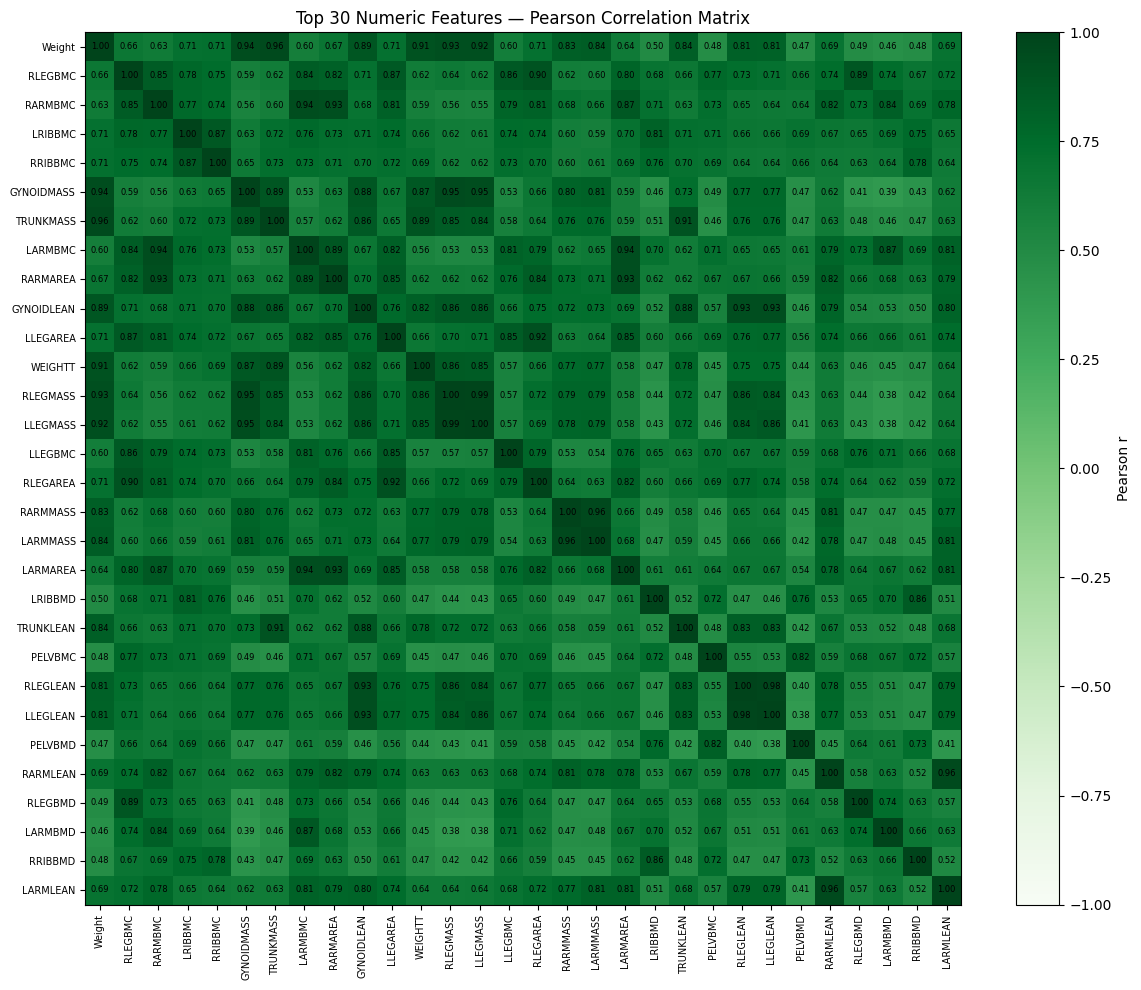

In [18]:
import numpy as np
import pandas as pd

top30_num_exist = [c for c in top30_num if c in df.columns]
num30_df = df[top30_num_exist].select_dtypes(include=[np.number]).copy()

corr30_num = num30_df.corr(method="pearson")
labels_num = corr30_num.columns.tolist()

fig, ax = plot_annotated_heatmap(
    mat=corr30_num.values,
    labels=labels_num,
    title="Top 30 Numeric Features — Pearson Correlation Matrix",
    vmin=-1, vmax=1,
    cmap="Greens",
    fmt="{:.2f}",
    fontsize=7,
    fig_size=(12, 10)
)

out_png = "corr_matrix_top30_numeric_annotated.png"
fig.savefig(out_png, dpi=600, bbox_inches="tight", facecolor="white")
print("Saved:", out_png)

plt.show()
plt.close(fig)


# Section 5
## 2) Top 30 CATEGORICAL association matrix (Cramér’s V annotated)

Top30 categorical features: ['Pathology', 'Diagnosis', 'Pathology.new', 'Classification', 'Etiology', 'Osteoporosis', 'Spine.BD', 'Bone.Disease', 'Wholebody.BD', 'Hip.BD', 'Agecat', 'Neck.BD', 'Menopausal.Female', 'Pt.Group', 'CHILD.Class', 'Condition', 'Blood.Group', 'Center.BMD']
Saved: cramersV_top30_categorical_annotated.png


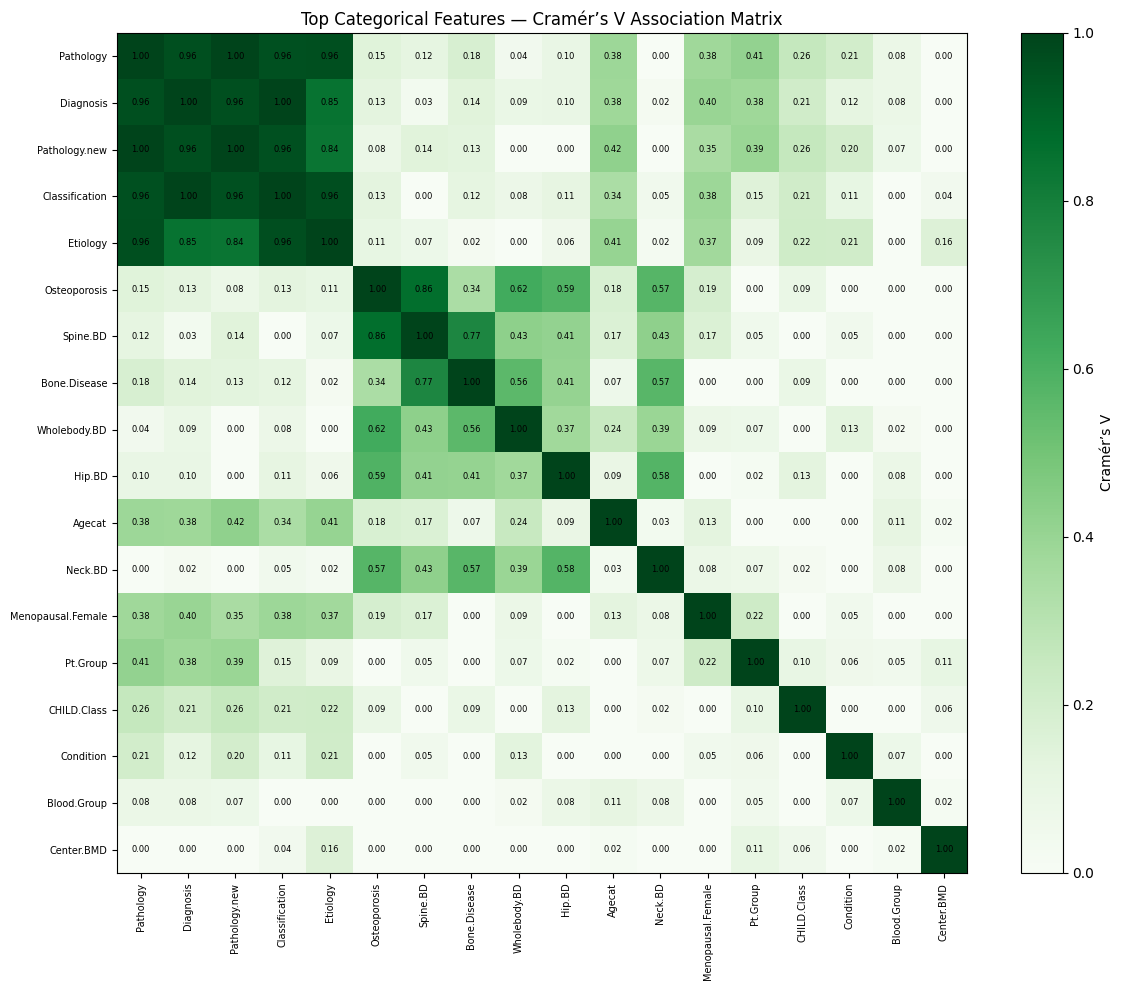

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 0) Define top30_cat if not already defined
# ---------------------------
if "top30_cat" not in globals():
    cat_df = df.select_dtypes(include=["object", "category", "bool"]).copy()
    if "Expire" in cat_df.columns:
        cat_df = cat_df.drop(columns=["Expire"])

    # score categorical columns by number of unique values (simple + robust)
    # (you can replace this scoring if you already have your own method)
    uniq = cat_df.nunique(dropna=True).sort_values(ascending=False)
    top30_cat = uniq.head(30).index.tolist()

print("Top30 categorical features:", top30_cat)

# ---------------------------
# 1) Cramér’s V (bias-corrected)
# ---------------------------
def cramers_v(x, y) -> float:
    confusion = pd.crosstab(x, y)
    n = confusion.values.sum()
    if n == 0:
        return np.nan

    obs = confusion.values
    row_sum = obs.sum(axis=1, keepdims=True)
    col_sum = obs.sum(axis=0, keepdims=True)
    expected = row_sum @ col_sum / n

    with np.errstate(divide="ignore", invalid="ignore"):
        chi2 = np.nansum((obs - expected) ** 2 / expected)

    r, k = confusion.shape
    if r <= 1 or k <= 1:
        return 0.0

    phi2 = chi2 / n

    # Bias correction
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

# ---------------------------
# 2) Annotated heatmap (returns fig)
# ---------------------------
def plot_annotated_heatmap(
    mat, labels, title,
    vmin=0, vmax=1, cmap="Greens",
    fmt="{:.2f}", fontsize=7,
    fig_size=(12, 10)
):
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.imshow(mat, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Cramér’s V")

    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize)
    ax.set_yticklabels(labels, fontsize=fontsize)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, fmt.format(mat[i, j]), ha="center", va="center", fontsize=fontsize-1)

    fig.tight_layout()
    return fig, ax

# ---------------------------
# 3) Build Cramér’s V matrix
# ---------------------------
top30_cat_exist = [c for c in top30_cat if c in df.columns]
cat30_df = df[top30_cat_exist].copy()

for c in cat30_df.columns:
    cat30_df[c] = cat30_df[c].astype("category")

cols = cat30_df.columns.tolist()
m = len(cols)
V = np.zeros((m, m), dtype=float)

for i in range(m):
    V[i, i] = 1.0
    for j in range(i + 1, m):
        v = cramers_v(cat30_df.iloc[:, i], cat30_df.iloc[:, j])
        V[i, j] = v
        V[j, i] = v

# ---------------------------
# 4) Plot + SAVE high-quality PNG
# ---------------------------
fig, ax = plot_annotated_heatmap(
    mat=V,
    labels=cols,
    title="Top Categorical Features — Cramér’s V Association Matrix",
    vmin=0, vmax=1,
    cmap="Greens",
    fmt="{:.2f}",
    fontsize=7,
    fig_size=(12, 10)
)

out_png = "cramersV_top30_categorical_annotated.png"
fig.savefig(out_png, dpi=600, bbox_inches="tight", facecolor="white")
print("Saved:", out_png)

plt.show()
plt.close(fig)


# ✅ Section 6 Code: Combined Redundancy Report (Numeric + Categorical)

In [20]:
import numpy as np
import pandas as pd

# -----------------------------
# Inputs (use your existing lists)
# -----------------------------
# top30_num  : list of top numeric feature names
# top30_cat  : list of top categorical feature names
# df         : your original dataframe

# Safety: keep only columns that exist
top30_num_exist = [c for c in top30_num if c in df.columns]
top30_cat_exist = [c for c in top30_cat if c in df.columns]

print("Top30 numeric used:", len(top30_num_exist))
print("Top categorical used:", len(top30_cat_exist))

# -----------------------------
# 1) NUMERIC redundancy report (Pearson)
# -----------------------------
num_df = df[top30_num_exist].select_dtypes(include=[np.number]).copy()
corr = num_df.corr(method="pearson")

# Extract upper triangle pairs with signed + abs correlation
upper_mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
pairs_num = (
    corr.where(upper_mask)
        .stack()
        .reset_index()
)
pairs_num.columns = ["Feature_1", "Feature_2", "Corr"]
pairs_num["AbsCorr"] = pairs_num["Corr"].abs()
pairs_num = pairs_num.sort_values("AbsCorr", ascending=False).reset_index(drop=True)

print("\n--- Top 20 numeric correlated pairs (Pearson r) ---")
print(pairs_num.head(20).to_string(index=False))

# Threshold counts (tune if you want)
thr_num_strong = 0.90
thr_num_medium = 0.70

num_strong = int((pairs_num["AbsCorr"] >= thr_num_strong).sum())
num_medium = int(((pairs_num["AbsCorr"] >= thr_num_medium) & (pairs_num["AbsCorr"] < thr_num_strong)).sum())

# Save numeric pairs
pairs_num.to_csv("section6_numeric_pairs_top30.csv", index=False)
print("\nSaved: section6_numeric_pairs_top30.csv")

# -----------------------------
# 2) CATEGORICAL redundancy report (Cramér’s V)
# -----------------------------
def cramers_v(x, y) -> float:
    confusion = pd.crosstab(x, y)
    n = confusion.values.sum()
    if n == 0:
        return np.nan

    obs = confusion.values
    row_sum = obs.sum(axis=1, keepdims=True)
    col_sum = obs.sum(axis=0, keepdims=True)
    expected = row_sum @ col_sum / n

    with np.errstate(divide="ignore", invalid="ignore"):
        chi2 = np.nansum((obs - expected) ** 2 / expected)

    r, k = confusion.shape
    if r <= 1 or k <= 1:
        return 0.0

    phi2 = chi2 / n

    # Bias correction
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

cat_df = df[top30_cat_exist].copy()
for c in cat_df.columns:
    cat_df[c] = cat_df[c].astype("category")

# Compute Cramér's V for all pairs (upper triangle only)
cat_pairs = []
cols = cat_df.columns.tolist()
m = len(cols)

for i in range(m):
    for j in range(i + 1, m):
        v = cramers_v(cat_df.iloc[:, i], cat_df.iloc[:, j])
        cat_pairs.append((cols[i], cols[j], v))

pairs_cat = pd.DataFrame(cat_pairs, columns=["Feature_1", "Feature_2", "CramersV"])
pairs_cat = pairs_cat.sort_values("CramersV", ascending=False).reset_index(drop=True)

print("\n--- Top 20 categorical associated pairs (Cramér’s V) ---")
print(pairs_cat.head(20).to_string(index=False))

# Threshold counts
thr_cat_strong = 0.80
thr_cat_medium = 0.40

cat_strong = int((pairs_cat["CramersV"] >= thr_cat_strong).sum())
cat_medium = int(((pairs_cat["CramersV"] >= thr_cat_medium) & (pairs_cat["CramersV"] < thr_cat_strong)).sum())

pairs_cat.to_csv("section6_categorical_pairs_top.csv", index=False)
print("\nSaved: section6_categorical_pairs_top.csv")

# -----------------------------
# 3) Compact summary table for paper
# -----------------------------
summary = pd.DataFrame([
    {
        "Group": "Numeric (Pearson r) — Top30",
        "Pairs_Total": len(pairs_num),
        f"Strong (|r| ≥ {thr_num_strong})": num_strong,
        f"Moderate ({thr_num_medium} ≤ |r| < {thr_num_strong})": num_medium
    },
    {
        "Group": "Categorical (Cramér’s V) — Selected",
        "Pairs_Total": len(pairs_cat),
        f"Strong (V ≥ {thr_cat_strong})": cat_strong,
        f"Moderate ({thr_cat_medium} ≤ V < {thr_cat_strong})": cat_medium
    }
])

print("\n=== Section 6 Summary (Redundancy Counts) ===")
print(summary.to_string(index=False))

summary.to_csv("section6_redundancy_summary.csv", index=False)
print("\nSaved: section6_redundancy_summary.csv")


Top30 numeric used: 30
Top categorical used: 18

--- Top 20 numeric correlated pairs (Pearson r) ---
 Feature_1  Feature_2     Corr  AbsCorr
  RLEGMASS   LLEGMASS 0.985916 0.985916
  RLEGLEAN   LLEGLEAN 0.979523 0.979523
  RARMMASS   LARMMASS 0.962276 0.962276
    Weight  TRUNKMASS 0.957409 0.957409
  RARMLEAN   LARMLEAN 0.955238 0.955238
GYNOIDMASS   RLEGMASS 0.946196 0.946196
GYNOIDMASS   LLEGMASS 0.945303 0.945303
   RARMBMC    LARMBMC 0.939906 0.939906
    Weight GYNOIDMASS 0.938352 0.938352
   LARMBMC   LARMAREA 0.935194 0.935194
GYNOIDLEAN   RLEGLEAN 0.932647 0.932647
GYNOIDLEAN   LLEGLEAN 0.932383 0.932383
  RARMAREA   LARMAREA 0.930922 0.930922
   RARMBMC   RARMAREA 0.927150 0.927150
    Weight   RLEGMASS 0.926918 0.926918
    Weight   LLEGMASS 0.923498 0.923498
  LLEGAREA   RLEGAREA 0.921619 0.921619
    Weight    WEIGHTT 0.912287 0.912287
 TRUNKMASS  TRUNKLEAN 0.905449 0.905449
   RLEGBMC   RLEGAREA 0.901874 0.901874

Saved: section6_numeric_pairs_top30.csv

--- Top 20 catego